# Modeling Non-Linear Patterns with Activation Functions

Welcome back to the delivery challenge!



## The Problem with Linear Models

In the last lab, your simple linear model performed well on bike-only data, but it struggled when cars were added. The reason was simple: your model could only learn **straight lines**, but the new data followed a **curve**. 

As distances increased, delivery times stopped following a straight line. Why did your model start to fail when you added cars? It all came down to your model's assumption. A linear model treats every mile as needing the same amount of time, but in reality, it's much more complicated. These first few miles beyond bike range hit dense city traffic. And further out, cars reach highways and move faster. The relationship **curves**.



## Why Adding More Neurons Isn't Enough

You might think: "Let's just add more neurons. If one neuron learns one relationship, maybe multiple neurons can capture more complexity."

But here's the problem: **Simply adding more linear neurons is not the solution. The model's output would still be a straight line.**


In [1]:
from IPython.display import Image

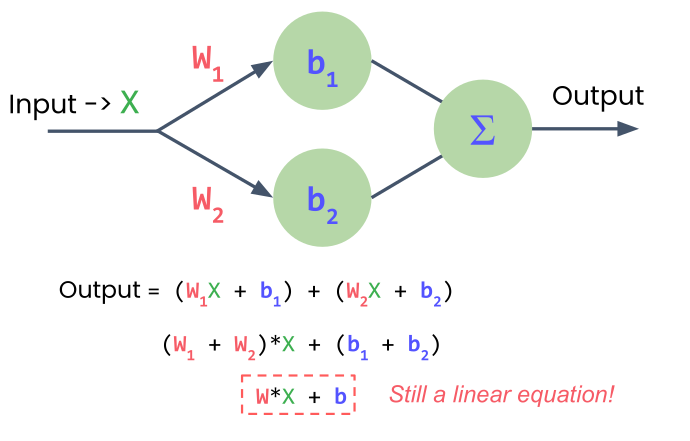

In [2]:
Image('../../assets/two_neurons_still_linear.png')

When you have just one neuron, it produces your final prediction, so it is the output layer. But when you add a second neuron, now you have two outputs from your single input, and you need a single prediction in your final output. So you add another neuron to combine these two outputs into one final output, and now those two neurons are considered a **hidden layer**.

These neurons independently calculate the weighted sum from the input. But here's the problem: **That's still just a linear equation no matter how many neurons you stack like this.** If all operations on a single input are linear—simply multiplying by weights and adding biases—you'll always end up with a straight line.

> Try it out yourself! You can experiment with adding more neurons here: [https://playground.tensorflow.org/](https://playground.tensorflow.org/#activation=linear&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.21856&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) where we set the **Activation function to: `linear`** (i.e., no activation function).


## The Solution: Activation Functions

To learn curves and not just straight lines, your model needs something more than a linear transformation. It needs **non-linear activation functions**. These functions add just enough complexity to help the model learn more interesting patterns.

A neuron starts by computing a linear transformation of its input. But instead of sending that raw number straight out, we pass it through an activation function. **This small change, adding a nonlinear transformation, is what lets your model learn much richer patterns.**


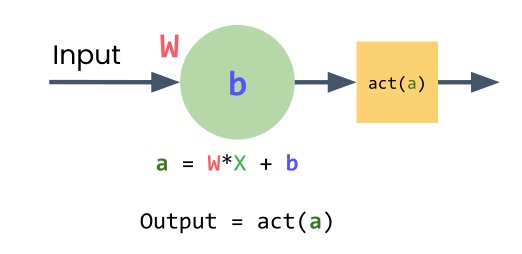

In [3]:
Image('../../assets/activation_after_neuron.png')


## Introducing ReLU

In this lab, you'll use the most popular and powerful activation function, **ReLU (Rectified Linear Unit)**. It's incredibly simple and surprisingly powerful.

Here's what ReLU does:
- **If the input is negative, output 0**
- **If the input is positive, just pass it through unchanged**

In [ ]:
def my_relu(input: float):
    if input > 0:
        return input
    else:
        return 0

assert my_relu(-2.4) == 0
assert my_relu(3.6) == 3.6

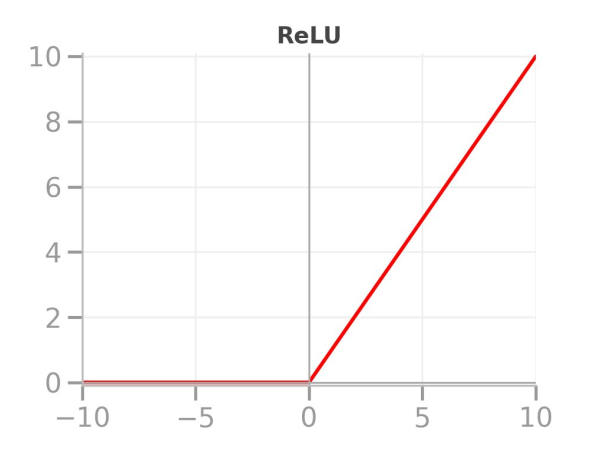

In [4]:
Image('../../assets/relu.png')


It's as simple as that! In PyTorch, it takes just one line to add ReLU to your model.


## How ReLU Creates Curves

When you add ReLU to a single neuron, your neuron will start by computing `W × Distance + B`. Without ReLU, this will give you a straight line. But with ReLU:
- When `W × Distance + B` is **negative**, the output is **0**, which is a flat line
- When it's **positive**, the output follows the line normally

**You've just escaped the world of straight lines. You now have a bend, a corner where the behavior changes.**

The bend occurs where `W × Distance + B = 0`, which effectively gives us `Distance = -B/W`—where it stops outputting 0 and starts responding to the input.


## Multiple Neurons, Multiple Bends

Think about your city transportation data. The pattern doesn't just bend once. It curves, shifting gradually across different distances as traffic conditions change. **So if one neuron gives us one bend, then maybe multiple neurons will give us multiple bends.**

Each neuron has its own weight and bias, and that means that each neuron activates at a different distance:
- Neuron 1 might activate right around 3 miles where the traffic starts
- Neuron 2 might activate right around 8 miles as we're entering the highways
- Neuron 3 might activate at around 15 miles when we're at full highway speeds

When you add their outputs together, their combined output approximates your complex curve. **With enough neurons, each learning where to activate and how strongly to contribute, you can approximate any smooth curve.**


In [ ]:
Image('../../assets/five_relu_activated_neurons.png')


## What You'll Do in This Lab

In this lab, you will:

* Prepare the combined bike and car delivery data, this time applying a technique called **normalization** to help your model train more effectively.
* Build a *non-linear* neural network using the **ReLU** activation function.
* Train your new model to learn the complex, curved relationship in the data.
* Predict delivery times using your new model and see if it can finally succeed where the linear one failed.

Let's put this knowledge to work!

## Imports

Let's start with the imports. These will give you:
- **`torch`**: PyTorch's core functionality
- **`torch.nn`**: Components for building neural networks (abbreviated as `nn`), including activation functions like ReLU
- **`torch.optim`**: Tools for training these networks (abbreviated as `optim`)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import helper_utils

## Preparing the Non-Linear Data

Start by loading the same dataset that caused problems at the end of the last lab. This is the combined data for both bike and car deliveries.

In [ ]:
# Combined dataset: bikes for short distances, cars for longer ones
distances = torch.tensor([
    [1.0], [1.5], [2.0], [2.5], [3.0], [3.5], [4.0], [4.5], [5.0], [5.5],
    [6.0], [6.5], [7.0], [7.5], [8.0], [8.5], [9.0], [9.5], [10.0], [10.5],
    [11.0], [11.5], [12.0], [12.5], [13.0], [13.5], [14.0], [14.5], [15.0], [15.5],
    [16.0], [16.5], [17.0], [17.5], [18.0], [18.5], [19.0], [19.5], [20.0]
], dtype=torch.float32)

# Corresponding delivery times in minutes
times = torch.tensor([
    [6.96], [9.67], [12.11], [14.56], [16.77], [21.7], [26.52], [32.47], [37.15], [42.35],
    [46.1], [52.98], [57.76], [61.29], [66.15], [67.63], [69.45], [71.57], [72.8], [73.88],
    [76.34], [76.38], [78.34], [80.07], [81.86], [84.45], [83.98], [86.55], [88.33], [86.83],
    [89.24], [88.11], [88.16], [91.77], [92.27], [92.13], [90.73], [90.39], [92.98]
], dtype=torch.float32)

* As you will see from running the code below, the data plot follows a non-linear pattern.

In [ ]:
helper_utils.plot_data(distances, times)

### A New Step: Normalizing the Data

Before building your model, you will apply a quick data preparation step called **normalization**. This is a standard technique that makes the training process more stable and effective by adjusting the scale of the data.

#### Why Normalize?

Neural networks are sensitive to the scale of input data. When features have very different scales (like distances ranging from 1-20 miles and times ranging from 7-93 minutes), the training process can become unstable. Large values can dominate the learning process, making it harder for the model to learn effectively. Normalization helps by:

- **Preventing large distance values from dominating the learning process**: Without normalization, the model might focus too much on the larger values and ignore smaller but equally important patterns.
- **Keeping gradients stable during training**: When values are on similar scales, the gradients (which guide the learning process) remain more balanced, leading to smoother and more reliable training.

This adjustment helps prevent large distance values from dominating the learning process and keeps gradients stable during training. You will explore this topic in greater detail in a later module.

#### Standardization (Z-Score Normalization)

The specific technique you'll use is called **standardization** (or z-score normalization). This converts your original data into a new, normalized scale where:
- The mean becomes 0
- The standard deviation becomes 1
- Values are typically in the range of approximately -3 to +3

For your data, this converts:
- Distances from `1.0 to 20.0 miles` → normalized scale
- Times from approximately `7 to 93 minutes` → normalized scale

* You will calculate the mean and standard deviation for the `distances` and `times` tensors.
* You will then apply standardization to each tensor using its respective mean and standard deviation, which creates new normalized tensors named `distances_norm` and `times_norm`.
* The formula for standardization is: `normalized_value = (value - mean) / standard_deviation`

In [ ]:
# Calculate the mean and standard deviation for the 'distances' tensor
distances_mean = distances.mean()
distances_std = distances.std()

# Calculate the mean and standard deviation for the 'times' tensor
times_mean = times.mean()
times_std = times.std()

# Apply standardization to the distances.
distances_norm = (distances - distances_mean) / distances_std

# Apply standardization to the times.
times_norm = (times - times_mean) / times_std

* You will notice the axes now show the data on a new, normalized scale, with distance ranging from approximately `-1.7 to 1.7` and time from `-2.0 to 1.0`.
* Despite this change in scale, the underlying curved pattern of the data remains exactly the same.

In [ ]:
helper_utils.plot_data(distances_norm, times_norm, normalize=True)

## Building the Non-Linear Model

With your normalized data ready, you can now build a model capable of learning its curved pattern. You will define the model's architecture, which now includes a `ReLU` activation function. This structure is what gives your model the ability to learn non-linear relationships.

### Understanding the Architecture

In PyTorch, you only code the layers that compute. The input is just your data. And ReLU, well that's an activation function that transforms values and not a separate layer in this count.

Let's break down the architecture:

* **`nn.Linear(1, 3)`**: This is your **first hidden layer**. 
    * The `1` means one input feature (the normalized distance)
    * The `3` means three neurons, so this layer outputs three values
    * Each of these three neurons independently calculates a weighted sum from the input: `W × Distance + B`
    * Each neuron has its own weight and bias, which means each neuron will activate at a different distance

* **`nn.ReLU()`**: This applies the ReLU activation function to the output of each of the three neurons from the hidden layer. 
    * This is the crucial non-linear step that allows your model to create "bends" and learn curves instead of just straight lines
    * In PyTorch, activation functions are usually applied element-wise to each neuron in a layer, one by one
    * Each neuron's output passes through ReLU: if the value is negative, it becomes 0; if positive, it passes through unchanged
    * This creates the "bends" where each neuron activates at different points

* **`nn.Linear(3, 1)`**: This is your **output layer**. 
    * It takes the three activated (transformed) values from the previous step as its input
    * It combines them with a single neuron to produce one final output, which is your predicted (normalized) delivery time
    * This layer learns how to weight and combine the contributions from each of the three neurons

### How It All Works Together

This creates a neural network with **1 hidden layer containing 3 neurons**. Here's the flow:

1. **Input**: Normalized distance (single value)
2. **Hidden Layer**: Three neurons each compute `W × Distance + B`, creating three intermediate values
3. **ReLU Activation**: Each of the three values passes through ReLU, creating potential "bends" at different activation points
4. **Output Layer**: The three activated values are combined into a single prediction

Each neuron in the hidden layer learns where to activate (its own bend point) and how strongly to contribute. When you add their outputs together in the output layer, their combined output approximates your complex curve. **With enough neurons, each learning where to activate and how strongly to contribute, you can approximate any smooth curve.**

If you want a smoother curve, just increase the number of neurons in your first layer. The more neurons you have, the more "bends" your model can create, allowing it to capture more complex patterns.

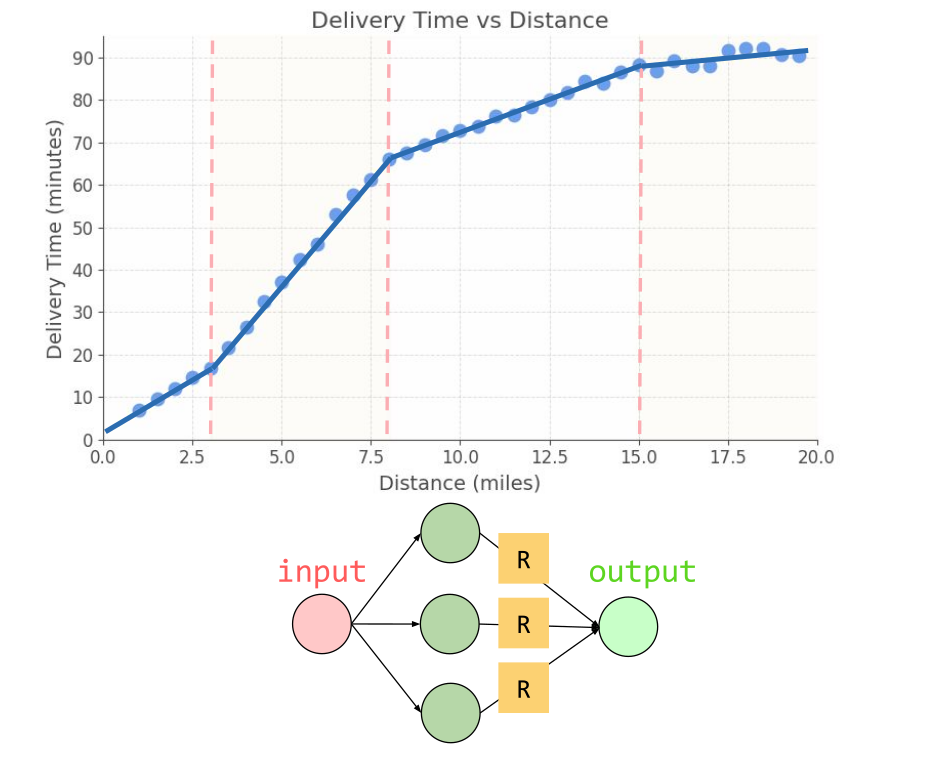

In [5]:
Image('../../assets/three_relu_activated_neurons.png')

In [ ]:
# This line ensures that your results are reproducible and consistent every time.
torch.manual_seed(27)

model = nn.Sequential(
    nn.Linear(1, 3),
    nn.ReLU(),
    nn.Linear(3, 1)
)

## Training

* Define the loss function and the optimizer for training.

In [ ]:
# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

A **single training epoch**, which is one full pass through the dataset. Each iteration over a **single batch** of data within that epoch is called a **step**.

With your model and training tools ready, you can begin the training process.

* You will run the training loop for `3000` epochs (more than Lab 1 because the non-linear pattern is more complex and requires more training). This will repeatedly feed the *normalized* data to your model, measure the error, and adjust the model's parameters to improve its predictions.
* The second half of the code includes a live plot, allowing you to watch in real time as your model's prediction line adapts to fit the curved data. The live plot helps you see how your model gradually learns to fit the curve, starting with a poor fit and improving over time.

**IMPORTANT NOTE**: As the plot updates in real time during training, you might notice a flickering effect. This is the expected behavior of the live visualization and not an issue with your screen.

In [ ]:
# Training loop
for epoch in range(3000):
    # Reset the optimizer's gradients
    optimizer.zero_grad()
    # Make predictions (forward pass)
    outputs = model(distances_norm)
    # Calculate the loss
    loss = loss_function(outputs, times_norm)
    # Calculate adjustments (backward pass)
    loss.backward()
    # Update the model's parameters
    optimizer.step()

    # Create a live plot every 50 epochs
    if (epoch + 1) % 50 == 0:
        helper_utils.plot_training_progress(
            epoch=epoch,
            loss=loss,
            model=model,
            distances_norm=distances_norm,
            times_norm=times_norm
        )

print("\nTraining Complete.")
print(f"\nFinal Loss: {loss.item()}")

## Checking the Final Fit 

Now that training is complete, you will visualize the result.

* You will plot your model's final predicted curve against the original data points.
* This lets you visually inspect how well your non-linear model learned to fit the complex data pattern.

In [ ]:
helper_utils.plot_final_fit(model, distances, times, distances_norm, times_std, times_mean)

<br>

Congratulations! You have successfully trained your first **non-linear** neural network in PyTorch!

Where the simple linear model from the last lab failed, your new model with a `ReLU` activation function succeeded. As you can see from the plot, your model learned to capture the complex, curved relationship in the combined bike and car delivery data.

## Making a Prediction

With your fully trained non-linear model, you can now use it to make a prediction for a new delivery. The process is slightly different now because your model was trained on *normalized* data.

### The Normalization Challenge

When you train a model on normalized data, you must remember that **your model has no idea about the original scales (miles and minutes). It only understands the normalized scale it was trained on.**

This means you need to handle two transformations:

1. **Normalize the input**: Before making a prediction, you must convert your new input distance from the original scale (miles) to the normalized scale using the same mean and standard deviation from your training data. This step is **CRITICAL**—if you feed the model raw miles, it will produce meaningless results because it expects normalized values.

2. **De-normalize the output**: After the model provides its prediction, you must convert the prediction from its normalized scale back into an understandable value in minutes. The model's output is in normalized units, not actual minutes, so you need to reverse the standardization process.

### The Prediction Process

* First, you will take the new input distance and **normalize** it using the same mean and standard deviation from your training data. 
    * Use the formula: `normalized_distance = (distance - distances_mean) / distances_std`
    * This ensures the input is on the same scale the model was trained on

* After the model provides its prediction, you must **de-normalize** the output. 
    * Use the reverse formula: `actual_time = (normalized_time × times_std) + times_mean`
    * This converts the prediction from its normalized scale back into an understandable value in minutes

* Finally, the code uses this actual predicted time to run the decision logic. For this prediction, assume your company now promises deliveries within 45 minutes (instead of 30 minutes from Lab 1) and wants to know which vehicle to use.

In [ ]:
distance_to_predict = 5.1

In [ ]:
# Use the torch.no_grad() context manager for efficient prediction
with torch.no_grad():
    # Normalize the input distance
    distance_tensor = torch.tensor([[distance_to_predict]], dtype=torch.float32)
    new_distance_norm = (distance_tensor - distances_mean) / distances_std
    
    # Get the normalized prediction from the model
    predicted_time_norm = model(new_distance_norm)
    
    # De-normalize the output to get the actual time in minutes
    predicted_time_actual = (predicted_time_norm * times_std) + times_mean
    
    # --- Decision Making Logic ---
    print(f"Prediction for a {distance_to_predict}-mile delivery: {predicted_time_actual.item():.1f} minutes")
    
    # First, check if the delivery is possible within the 45-minute timeframe
    if predicted_time_actual.item() > 45:
        print("\nDecision: Do NOT promise the delivery in under 45 minutes.")
    else:
        # If it is possible, then determine the vehicle based on the distance
        if distance_to_predict <= 3:
            print(f"\nDecision: Yes, delivery is possible. Since the distance is {distance_to_predict} miles (<= 3 miles), use a bike.")
        else:
            print(f"\nDecision: Yes, delivery is possible. Since the distance is {distance_to_predict} miles (> 3 miles), use a car.")

## Conclusion

You have now built and trained both a simple linear model and a more powerful non-linear model in PyTorch. In this lab, you saw firsthand how adding a non-linear activation function like **ReLU** gave your model the ability to succeed where the linear model had failed.

You have moved beyond fitting straight lines and can now capture the complex, curved patterns that are common in real-world data. You also learned a practical data preparation technique, normalization, that helps make the training process more stable and effective.

### About Activation Functions

We've been using ReLU because it's the workhorse of modern deep learning. It's fast, it's effective, and it's widely used. But it's not the only activation function out there:

- **Sigmoid**: Squashes your outputs into a range between 0 and 1, great for probabilities
- **Tanh**: Maps your values to a range between -1 and +1, really useful for many tasks
- And there are lots of others, too

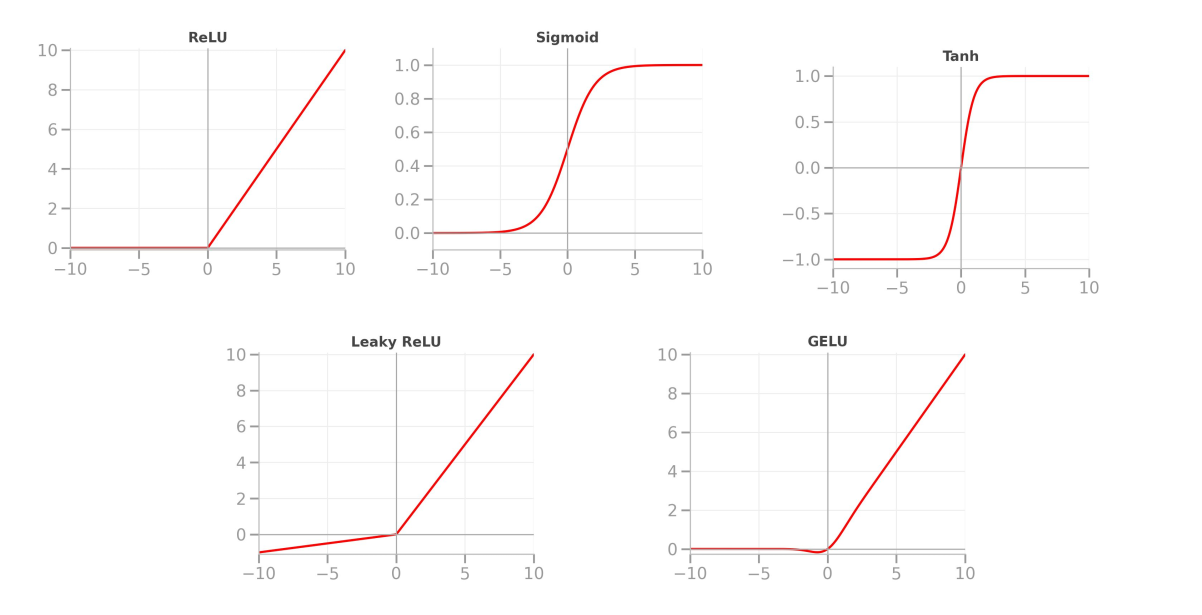

In [6]:
Image('../../assets/activation_functions.png')

If you want to dive deeper, there are a number of great resources, such as PyTorch.org's documentation and other deep learning specializations. But honestly, for most situations, **ReLU is all you need**.



### What's Next?

With these fundamental skills of building architectures, preparing data, and training models, you are well prepared for the next step. In the upcoming module, you will build on this foundation to tackle new kinds of problems, like classification, and dive even deeper into the mechanics of how neural networks learn.